In [2]:
import numpy as np
import pandas as pd
import json
import os

## Load latest full error

In [341]:
full_err_df = pd.read_csv("Full/full_err.csv", index_col=0)
full_err_df['accumulated_error'] = np.abs(full_err_df['accumulated_error'])
# full_err_df = full_err_df.query('N > 1000')

## Error Tests

### Test 1: train test split base (mae)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import HuberRegressor

# Features and target
X = full_err_df[['N', 'theta', 'dt', 'I']]
y = full_err_df['accumulated_error']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing: Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model: Random Forest Regressor
# model = RandomForestRegressor(n_estimators=100, random_state=42)
model = HuberRegressor()
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.6f}")

# Example Prediction for an arbitrary input
example_input = {'N': 100, 'theta': 0.2, 'dt': 6.25e-05, 'I': 5000}
example_scaled = scaler.transform(pd.DataFrame([example_input]))
predicted_error = model.predict(example_scaled)
print(f"Predicted Accumulated Energy Error: {predicted_error[0]:.6f}")

Mean Absolute Error: 8183.134219
Predicted Accumulated Energy Error: -779.361373


### Test 2: Feature subset CV starting tests

In [ ]:
from sklearn.linear_model import HuberRegressor

# Define dataset and parameters
input_features = ['N', 'theta', 'dt', 'I']
target_feature = 'accumulated_error'

# Define the model pipeline
pipeline = Pipeline(steps=[
    # ('normalize', QuantileTransformer()),
    ('model', HuberRegressor())
])

# Wrap with TransformedTargetRegressor
model = TransformedTargetRegressor(
    regressor=pipeline, 
    transformer=FunctionTransformer(lambda x:x)
)

# Define hyperparameter grid
model_params = {
    'regressor__model__epsilon': [1.35, 1.5, 1.75],
    'regressor__model__alpha': [0.0001, 0.001, 0.01],
}

# Run feature subset evaluation using Random CV
best_result_hr, res_hr = run_feature_subset_cv(
    f_full=full_err_df,
    input_features=input_features,
    target_feature=target_feature,
    model=model,
    model_params=model_params,
    use_feature_subsets=False,
    use_gpu_cv=False  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_hr['features'])
print("Best parameters:", best_result_hr['best_params'])
print("Best MAE:", best_result_hr['best_mae'])
print("Best MAPE:", best_result_hr['best_mape'])

# # Run feature subset evaluation using GPU split CV
# best_result_hr, res_hr = run_feature_subset_cv(
#     f_full=f_full,
#     input_features=input_features,
#     target_feature=target_feature,
#     model=model,
#     model_params=model_params,
#     use_feature_subsets=True,
#     use_gpu_cv=True  # Set to False to use regular KFold
# )

# # Display the best result
# print("Best feature subset:", best_result_hr['features'])
# print("Best parameters:", best_result_hr['best_params'])
# print("Best MAE:", best_result_hr['best_mae'])
# print("Best MAPE:", best_result_hr['best_mape'])


### Test 3: Feature subset CV with sampling (mae)

In [ ]:
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures

base_model_poly = Pipeline([
                    ('poly', PolynomialFeatures(5)),   # PolynomialFeatures step
                    ('ridge', Ridge())                # Ridge regression step
                ])

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import HuberRegressor

# Features and target
X = sampled_err_df[['N', 'theta', 'dt', 'I']]
y = sampled_err_df['accumulated_error']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing: Feature scaling
scaler = FunctionTransformer(lambda x:x**1/10)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model: Random Forest Regressor
# model = RandomForestRegressor(n_estimators=100, random_state=42)
model = base_model_poly
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.6f}")

# Example Prediction for an arbitrary input
example_input = {'N': 1000000, 'theta': 0.2, 'dt': 0.00625, 'I': 5000}
example_scaled = scaler.transform(pd.DataFrame([example_input]))
predicted_error = model.predict(example_scaled)
print(f"Predicted Accumulated Energy Error: {predicted_error[0]:.6f}")

# Cross validation training

### Wrapped Cross Validation Grid Search Trainer

In [342]:
from numpy import mean, absolute
from itertools import combinations
from sklearn.model_selection import KFold, GroupKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_absolute_percentage_error
from tqdm.notebook import tqdm  # Use tqdm.notebook for Jupyter
from IPython.display import clear_output
import os

def run_feature_subset_cv(
    f_full, 
    input_features, 
    target_feature, 
    model, 
    model_params, 
    extra_features=[], 
    use_gpu_cv=False,
    use_feature_subsets=True, 
    refit_error='MAPE', #MAPE OR MAE
    output_folder="CV_results"
):
    
    # Prepare input and target
    X_full = f_full[input_features+extra_features]
    y = f_full[target_feature]
    groups = f_full['Name'] if use_gpu_cv else None  # Use 'Name' for GroupKFold if applicable

    # Generate feature subsets or use all features
    if use_feature_subsets:
        feature_subsets = []
        for r in range(1, len(X_full[input_features].columns) + 1):  # r = subset size (1 to len(columns))
            feature_subsets.extend(combinations(X_full[input_features].columns, r))
    else:
        feature_subsets = [input_features]  # Use all input features as one subset
    
    # Define cross-validation strategy
    cv = GroupKFold(n_splits=5) if use_gpu_cv else KFold(n_splits=10, shuffle=True, random_state=1)

    # Define scoring metrics
    scorer_mae = make_scorer(mean_absolute_error, greater_is_better=False)
    scorer_mape = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

    # Store results
    results = []

    print(f"Testing {len(feature_subsets)} feature subset(s)...")
    with tqdm(total=len(feature_subsets), desc="Progress", unit="subset") as pbar, \
         tqdm(total=len(feature_subsets), desc="Custom Text", unit="update") as text_pbar:
                # Iterate over feature subsets
        for features in feature_subsets:
            # Subset the input data
            X = X_full[list(features)+extra_features]

            # Create GridSearchCV object
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=model_params,
                scoring={'MAE': scorer_mae, 'MAPE': scorer_mape},
                refit=refit_error,  # Optimize based on MAPE
                cv=cv.split(X, y, groups) if use_gpu_cv else cv,
                verbose=0,
                n_jobs=-1  # Use all available cores
            )

            # Fit GridSearchCV
            grid_search.fit(X, y)

            # Append results
            results.append({
                'features': list(features)+extra_features,
                'best_params': grid_search.best_params_,
                'best_mae': -grid_search.cv_results_['mean_test_MAE'][grid_search.best_index_],
                'best_mape': -grid_search.cv_results_['mean_test_MAPE'][grid_search.best_index_]
            })
            
            pbar.set_postfix({"current_subset": str(list(features)+extra_features), "current_mae": round(results[-1]['best_mae'], 3),"current_mape": round(results[-1]['best_mape'], 3)})
            text_pbar.set_description_str(
                f"> best_mae:{round(min(results, key=lambda x: x['best_mae'])['best_mae'], 3)}\n"+
                f"> best_mape:{round(min(results, key=lambda x: x['best_mape'])['best_mape'], 3)}\n"+
                f"> best_params:{min(results, key=lambda x: x['best_mape'])['best_params']}\n"+
                f"> best_features:{min(results, key=lambda x: x['best_mape'])['features']}")
            pbar.update(1)
            text_pbar.update(1)

    # Find the best result
    best_result = min(results, key=lambda x: x['best_mape'])
    
    # Extract the model name from the pipeline
    model_name = model.regressor.steps[-1][1].__class__.__name__

    # Determine CV type for the filename
    cv_type = "GPU_CV" if use_gpu_cv else "Random_CV"

    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Construct the base filename
    base_filename = f"{model_name}_{cv_type}_results"
    output_path = os.path.join(output_folder, f"{base_filename}.json")

    # If a file with the same name exists, append a number
    counter = 1
    while os.path.exists(output_path):
        output_path = os.path.join(output_folder, f"{base_filename}_{counter}.json")
        counter += 1

    # Include best result in the JSON data
    output_data = {
        "all_results": results,
        "best_result": best_result
    }

    # Write results to a JSON file
    with open(output_path, 'w') as json_file:
        json.dump(output_data, json_file, indent=4, default=str)  # Use default=str for non-serializable data

    print(f"Results saved to {output_path}")
    
    return best_result,results


### Error dataset sampling (max 1000 by hardware)

In [343]:
# Sample by interval
interval = 1000  # Define the interval for I
sampled_err_df = full_err_df[(full_err_df['I'] % interval == 0) | (full_err_df['I'] == 2)]  # Sample rows where I is a multiple of the interval or equal to 0
print(full_err_df.shape)
print(sampled_err_df.shape)

(1000100, 5)
(1100, 5)


In [344]:
sampled_err_df['accumulated_error'].describe()

count    1.100000e+03
mean     1.305538e+04
std      2.849984e+04
min      4.488800e-10
25%      1.138416e-01
50%      6.329041e+02
75%      7.855092e+03
max      1.423876e+05
Name: accumulated_error, dtype: float64

### Transformers

In [427]:
# Define named functions for the transformations
def log10_transform(x):
    return np.log10(x)

def inverse_log10_transform(x):
    return np.power(10, x)

# Define the sequential transformer 
log10_scale_transformer = Pipeline(steps=[
    ('log10', FunctionTransformer(func=log10_transform, inverse_func=inverse_log10_transform)),  # Apply log10
    ('scaler', StandardScaler()),  # Apply MinMaxScaler
])

# Define the sequential transformer 
log_scale_transformer = Pipeline(steps=[
    ('log', FunctionTransformer(func=np.log, inverse_func=np.exp)),  # Apply log10
    ('scaler', StandardScaler()),  # Apply MinMaxScaler
])

### Huber tests
* Best Random CV **(MAPE 14.54):** CV_results/error/HuberRegressor_Random_CV_results_64.json

In [349]:
# from sklearn.preprocessing import PowerTransformer, QuantileTransformer,FunctionTransformer,MinMaxScaler
# from sklearn.linear_model import HuberRegressor


# # Define dataset and parameters
# input_features = ['N', 'theta', 'dt', 'I']
# target_feature = 'accumulated_error'


# # Define the model pipeline
# pipeline = Pipeline(steps=[
#     ('normalize', QuantileTransformer(n_quantiles=500)), # WORKS BETTER 
#     ('model', HuberRegressor())
# ])

# # Wrap with TransformedTargetRegressor
# model_huber = TransformedTargetRegressor(
#     regressor=pipeline, 
#     transformer=QuantileTransformer(n_quantiles=500)
#     # transformer=FunctionTransformer(lambda x:x)
# )

# # Define hyperparameter grid
# model_params_huber = {
#     'regressor__model__epsilon': [1,1.35, 1.5, 1.75, 2],
#     'regressor__model__alpha': [0.00001,0.0001, 0.001, 0.01,0.1,1],
# }

#### huber2

In [428]:
# Define the transformer for N and theta columns
transformer = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), ['theta']),
        ('log10', FunctionTransformer(func=log10_transform, inverse_func=inverse_log10_transform),['I']),  # Apply log10
        ('log', FunctionTransformer(func=np.log, inverse_func=np.exp), ['dt']),
        ('log10scale', log10_scale_transformer, ['N'])
    ],
    remainder='passthrough'  # Pass through the remaining columns as they are
)

# Define the model pipeline
pipeline = Pipeline(steps=[
    ('normalize', transformer), # WORKS BETTER 
    ('model', HuberRegressor()) ## SECOND BEST AND NICE GENERALIZING!!!! C=100,epsilon=0.0001
])

# Wrap with TransformedTargetRegressor
model_huber = TransformedTargetRegressor(
    regressor=pipeline, 
    transformer=log_scale_transformer
)

# Define hyperparameter grid
model_params_huber = {
    'regressor__model__epsilon': [1,1.35, 1.5, 1.75, 2],
    'regressor__model__alpha': [0.00001,0.0001, 0.001, 0.01,0.1,1],
}

In [448]:
# Run feature subset evaluation using Random CV
best_result_huber, res_huber = run_feature_subset_cv(
    f_full=sampled_err_df,
    input_features=input_features,
    target_feature=target_feature,
    model=model_huber,
    model_params=model_params_huber,
    output_folder="CV_results/error",
    use_feature_subsets=False,
    refit_error='MAPE',
    use_gpu_cv=False  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_huber['features'])
print("Best parameters:", best_result_huber['best_params'])
print("Best MAE:", best_result_huber['best_mae'])
print("Best MAPE:", best_result_huber['best_mape'])



Testing 1 feature subset(s)...


Progress:   0%|          | 0/1 [00:00<?, ?subset/s]

Custom Text:   0%|          | 0/1 [00:00<?, ?update/s]

Results saved to CV_results/error/HuberRegressor_Random_CV_results_69.json
Best feature subset: ['N', 'theta', 'dt', 'I']
Best parameters: {'regressor__model__alpha': 1e-05, 'regressor__model__epsilon': 2}
Best MAE: 38003.27994072322
Best MAPE: 23.828685010933167


### SVR tests
* Best Random CV **(MAPE 0.237):** CV_results/error/SVR_Random_CV_results_58.json

In [363]:
# from sklearn.preprocessing import PowerTransformer, QuantileTransformer,FunctionTransformer,MinMaxScaler
# from sklearn.svm import SVR


# # Define dataset and parameters
# input_features = ['N', 'theta', 'dt', 'I']
# target_feature = 'accumulated_error'

# # Define the model pipeline
# pipeline = Pipeline(steps=[
#     ('normalize', QuantileTransformer(n_quantiles=500)), # WORKS BETTER 
#     ('model', SVR()) ## SECOND BEST AND NICE GENERALIZING!!!! C=100,epsilon=0.0001
# ])

# # Wrap with TransformedTargetRegressor
# model_svr = TransformedTargetRegressor(
#     regressor=pipeline, 
#     transformer=QuantileTransformer(n_quantiles=500)
# )

# # Define hyperparameter grid
# model_params_svr = {
#     'regressor__model__C': [0.0001,0.001, 0.01, 0.1, 1, 10, 50,100],
#     'regressor__model__epsilon': [0.00001,0.0001, 0.001, 0.01, 0.1, 0.5, 1], 
#     'regressor__model__kernel': ['rbf']
# }


#### SVR 2

In [463]:
# Define the transformer for N and theta columns
transformer = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), ['theta']),
        ('log10', FunctionTransformer(func=log10_transform, inverse_func=inverse_log10_transform),['I']),  # Apply log10
        ('log', FunctionTransformer(func=np.log, inverse_func=np.exp), ['dt']),
        ('log10scale', log10_scale_transformer, ['N'])
    ],
    remainder='passthrough'  # Pass through the remaining columns as they are
)

# Define the model pipeline
pipeline = Pipeline(steps=[
    ('normalize', transformer), # WORKS BETTER 
    ('model', SVR()) ## SECOND BEST AND NICE GENERALIZING!!!! C=100,epsilon=0.0001
])

# Wrap with TransformedTargetRegressor
model_svr = TransformedTargetRegressor(
    regressor=pipeline, 
    transformer=log_scale_transformer
)

# Define hyperparameter grid
model_params_svr = {
    'regressor__model__C': [0.0001,0.001, 0.01, 0.1, 1, 10, 50,100,1000, 2000], 
    'regressor__model__epsilon': [0.00001,0.0001, 0.001, 0.01, 0.1, 0.5, 1], 
    'regressor__model__kernel': ['rbf']
}

In [464]:
# Run feature subset evaluation using Random CV
best_result_svr, res_svr = run_feature_subset_cv(
    f_full=sampled_err_df,
    input_features=input_features,
    target_feature=target_feature,
    model=model_svr,
    model_params=model_params_svr,
    output_folder="CV_results/error",
    use_feature_subsets=False,
    refit_error='MAPE',
    use_gpu_cv=False  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_svr['features'])
print("Best parameters:", best_result_svr['best_params'])
print("Best MAE:", best_result_svr['best_mae'])
print("Best MAPE:", best_result_svr['best_mape'])

Testing 1 feature subset(s)...


Progress:   0%|          | 0/1 [00:00<?, ?subset/s]

Custom Text:   0%|          | 0/1 [00:00<?, ?update/s]

Results saved to CV_results/error/SVR_Random_CV_results_68.json
Best feature subset: ['N', 'theta', 'dt', 'I']
Best parameters: {'regressor__model__C': 2000, 'regressor__model__epsilon': 1e-05, 'regressor__model__kernel': 'rbf'}
Best MAE: 1139.3407994292827
Best MAPE: 0.598072215280631


### DT tests
* Best Random CV **(MAPE 0.327):** CV_results/error/DecisionTreeRegressor_Random_CV_results_15.json

In [ ]:
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.svm import SVR, LinearSVR
# from sklearn.preprocessing import PowerTransformer, QuantileTransformer,FunctionTransformer,MinMaxScaler
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.linear_model import HuberRegressor, Ridge
# from sklearn.preprocessing import PolynomialFeatures


# # Define dataset and parameters
# input_features = ['N', 'theta', 'dt', 'I']
# target_feature = 'accumulated_error'

# # Define the model pipeline
# pipeline = Pipeline(steps=[
#     ('normalize', QuantileTransformer(n_quantiles=500)), # WORKS BETTER 
#     ('model', DecisionTreeRegressor(random_state=42))
# ])

# # Wrap with TransformedTargetRegressor
# model_dt = TransformedTargetRegressor(
#     regressor=pipeline, 
#     transformer=QuantileTransformer(n_quantiles=500)
# )

# # Define hyperparameter grid
# model_params_dt = {
#     'regressor__model__max_depth': [2,5,10, 20, None],
#     'regressor__model__min_samples_split': [2, 5, 10],
#     'regressor__model__min_samples_leaf': [1, 2, 4],
#     'regressor__model__max_features': [0.2, 0.4, 0.6, 0.8, 1.0]
# }


#### DT 2

In [383]:
# Define the transformer for N and theta columns
transformer = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), ['theta']),
        ('log10', FunctionTransformer(func=log10_transform, inverse_func=inverse_log10_transform),['I']),  # Apply log10
        ('log', FunctionTransformer(func=np.log, inverse_func=np.exp), ['dt']),
        ('log10scale', log10_scale_transformer, ['N'])
    ],
    remainder='passthrough'  # Pass through the remaining columns as they are
)

# Define the model pipeline
pipeline = Pipeline(steps=[
    ('normalize', transformer), # WORKS BETTER 
    ('model', DecisionTreeRegressor(random_state=42)) ## SECOND BEST AND NICE GENERALIZING!!!! C=100,epsilon=0.0001
])

# Wrap with TransformedTargetRegressor
model_dt = TransformedTargetRegressor(
    regressor=pipeline, 
    transformer=log_scale_transformer
)

# Define hyperparameter grid
model_params_dt = {
    'regressor__model__max_depth': [2,5,10, 20, None],
    'regressor__model__min_samples_split': [2, 5, 10],
    'regressor__model__min_samples_leaf': [1, 2, 4],
    'regressor__model__max_features': [0.2, 0.4, 0.6, 0.8, 1.0]
}


In [384]:
# Run feature subset evaluation using Random CV
best_result_dt, res_dt = run_feature_subset_cv(
    f_full=sampled_err_df,
    input_features=input_features,
    target_feature=target_feature,
    model=model_dt,
    model_params=model_params_dt,
    output_folder="CV_results/error",
    use_feature_subsets=False,
    refit_error='MAPE',
    use_gpu_cv=False  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_dt['features'])
print("Best parameters:", best_result_dt['best_params'])
print("Best MAE:", best_result_dt['best_mae'])
print("Best MAPE:", best_result_dt['best_mape'])

Testing 1 feature subset(s)...


Progress:   0%|          | 0/1 [00:00<?, ?subset/s]

Custom Text:   0%|          | 0/1 [00:00<?, ?update/s]

Results saved to CV_results/error/DecisionTreeRegressor_Random_CV_results_16.json
Best feature subset: ['N', 'theta', 'dt', 'I']
Best parameters: {'regressor__model__max_depth': 20, 'regressor__model__max_features': 1.0, 'regressor__model__min_samples_leaf': 1, 'regressor__model__min_samples_split': 5}
Best MAE: 456.9195122321847
Best MAPE: 0.37091862934847863


### GB tests
* Best Random CV **(MAPE 0.162):** CV_results/error/GradientBoostingRegressor_Random_CV_results_19.json

In [ ]:
# from sklearn.preprocessing import PowerTransformer, QuantileTransformer,FunctionTransformer,MinMaxScaler
# from sklearn.ensemble import GradientBoostingRegressor

# # Define dataset and parameters
# input_features = ['N', 'theta', 'dt', 'I']
# target_feature = 'accumulated_error'

# # Define the model pipeline
# pipeline = Pipeline(steps=[
#     ('normalize', QuantileTransformer(n_quantiles=500)), # WORKS BETTER 
        
#     ('model', GradientBoostingRegressor(random_state=42)) ## BEST YET n_estimators=500, learning_rate=0.1, max_depth=6, 
# ])

# # Wrap with TransformedTargetRegressor
# model_gb = TransformedTargetRegressor(
#     regressor=pipeline, 
#     transformer=QuantileTransformer(n_quantiles=500)
# )

# model_params_gb = {
#     'regressor__model__n_estimators': [50, 100, 200, 500],  # Number of boosting stages
#     'regressor__model__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],  # Step size shrinkage
#     'regressor__model__max_depth': [3, 5, 6, 7, 10],  # Maximum depth of each estimator
#     'regressor__model__min_samples_split': [2, 5, 10],  # Minimum samples required to split
#     'regressor__model__min_samples_leaf': [1, 2, 4],  # Minimum samples required in leaf nodes
#     'regressor__model__subsample': [0.6, 0.8, 1.0],  # Fraction of samples used per estimator
#     'regressor__model__max_features': [0.2, 0.4, 0.6, 0.8, 1.0]
# }

#### GB 2

In [388]:
# Define the transformer for N and theta columns
transformer = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), ['theta']),
        ('log10', FunctionTransformer(func=log10_transform, inverse_func=inverse_log10_transform),['I']),  # Apply log10
        ('log', FunctionTransformer(func=np.log, inverse_func=np.exp), ['dt']),
        ('log10scale', log10_scale_transformer, ['N'])
    ],
    remainder='passthrough'  # Pass through the remaining columns as they are
)

# Define the model pipeline
pipeline = Pipeline(steps=[
    ('normalize', transformer), # WORKS BETTER 
    ('model', GradientBoostingRegressor(random_state=42)) ## SECOND BEST AND NICE GENERALIZING!!!! C=100,epsilon=0.0001
])

# Wrap with TransformedTargetRegressor
model_gb = TransformedTargetRegressor(
    regressor=pipeline, 
    transformer=log_scale_transformer
)

# Define hyperparameter grid
model_params_gb = {
    'regressor__model__n_estimators': [50, 100, 200, 500],  # Number of boosting stages
    'regressor__model__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],  # Step size shrinkage
    'regressor__model__max_depth': [3, 5, 6, 7, 10],  # Maximum depth of each estimator
    'regressor__model__min_samples_split': [2, 5, 10],  # Minimum samples required to split
    'regressor__model__min_samples_leaf': [1, 2, 4],  # Minimum samples required in leaf nodes
    'regressor__model__subsample': [0.6, 0.8, 1.0],  # Fraction of samples used per estimator
    'regressor__model__max_features': [0.2, 0.4, 0.6, 0.8, 1.0]
}

In [389]:
# Run feature subset evaluation using Random CV
best_result_gb, res_gb = run_feature_subset_cv(
    f_full=sampled_err_df,
    input_features=input_features,
    target_feature=target_feature,
    model=model_gb,
    model_params=model_params_gb,
    output_folder="CV_results/error",
    use_feature_subsets=False,
    refit_error='MAPE',
    use_gpu_cv=False  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_gb['features'])
print("Best parameters:", best_result_gb['best_params'])
print("Best MAE:", best_result_gb['best_mae'])
print("Best MAPE:", best_result_gb['best_mape'])

Testing 1 feature subset(s)...


Progress:   0%|          | 0/1 [00:00<?, ?subset/s]

Custom Text:   0%|          | 0/1 [00:00<?, ?update/s]

Results saved to CV_results/error/GradientBoostingRegressor_Random_CV_results_20.json
Best feature subset: ['N', 'theta', 'dt', 'I']
Best parameters: {'regressor__model__learning_rate': 0.1, 'regressor__model__max_depth': 10, 'regressor__model__max_features': 1.0, 'regressor__model__min_samples_leaf': 2, 'regressor__model__min_samples_split': 2, 'regressor__model__n_estimators': 200, 'regressor__model__subsample': 0.8}
Best MAE: 204.2291813814884
Best MAPE: 0.18536737017612442


### ERT tests
* Best Random CV **(MAPE 0.162):** CV_results/error/GradientBoostingRegressor_Random_CV_results_19.json

In [392]:
# from sklearn.preprocessing import PowerTransformer, QuantileTransformer,FunctionTransformer,MinMaxScaler
from sklearn.ensemble import ExtraTreesRegressor


# # Define dataset and parameters
# input_features = ['N', 'theta', 'dt', 'I']
# target_feature = 'accumulated_error'

# # Define the model pipeline
# pipeline = Pipeline(steps=[
#     ('normalize', QuantileTransformer(n_quantiles=500)), # WORKS BETTER 
#     # ('normalize', PowerTransformer()),
        
#     ('model', ExtraTreesRegressor(random_state=42)) ## BEST YET n_estimators=500, learning_rate=0.1, max_depth=6, 
# ])

# # Wrap with TransformedTargetRegressor
# model_ert = TransformedTargetRegressor(
#     regressor=pipeline, 
#     transformer=QuantileTransformer(n_quantiles=500)
# )

# # Define hyperparameter grid
# model_params_ert = {
#     'regressor__model__n_estimators': [50, 100, 200, 300, 500],        # Number of trees in the forest
#     'regressor__model__max_depth': [10, 20, 30, None],
#     'regressor__model__min_samples_split': [2, 5, 10],
#     'regressor__model__min_samples_leaf': [1, 2, 4],
#     'regressor__model__max_features': [0.2, 0.4, 0.6, 0.8, 1.0],
# }

### ERT 2

In [409]:
# Define the transformer for N and theta columns
transformer = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), ['theta']),
        ('log10', FunctionTransformer(func=log10_transform, inverse_func=inverse_log10_transform),['I']),  # Apply log10
        ('log', FunctionTransformer(func=np.log, inverse_func=np.exp), ['dt']),
        ('log10scale', log10_scale_transformer, ['N'])
    ],
    remainder='passthrough'  # Pass through the remaining columns as they are
)

# Define the model pipeline
pipeline = Pipeline(steps=[
    ('normalize', transformer), # WORKS BETTER 
    ('model', ExtraTreesRegressor(random_state=42)) # TEST MONOTOIC CONSTRAINTS
])

# Wrap with TransformedTargetRegressor
model_ert = TransformedTargetRegressor(
    regressor=pipeline, 
    transformer=log_scale_transformer
)

# Define hyperparameter grid
model_params_ert = {
    'regressor__model__n_estimators': [50, 100, 200, 300, 500],        # Number of trees in the forest
    'regressor__model__max_depth': [10, 20, 30, None],
    'regressor__model__min_samples_split': [2, 5, 10],
    'regressor__model__min_samples_leaf': [1, 2, 4],
    'regressor__model__max_features': [0.2, 0.4, 0.6, 0.8, 1.0],
}

In [410]:
# Run feature subset evaluation using Random CV
best_result_ert, res_ert = run_feature_subset_cv(
    f_full=sampled_err_df,
    input_features=input_features,
    target_feature=target_feature,
    model=model_ert,
    model_params=model_params_ert,
    output_folder="CV_results/error",
    use_feature_subsets=False,
    refit_error='MAPE',
    use_gpu_cv=False  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_ert['features'])
print("Best parameters:", best_result_ert['best_params'])
print("Best MAE:", best_result_ert['best_mae'])
print("Best MAPE:", best_result_ert['best_mape'])

Testing 1 feature subset(s)...


Progress:   0%|          | 0/1 [00:00<?, ?subset/s]

Custom Text:   0%|          | 0/1 [00:00<?, ?update/s]

Results saved to CV_results/error/ExtraTreesRegressor_Random_CV_results_9.json
Best feature subset: ['N', 'theta', 'dt', 'I']
Best parameters: {'regressor__model__max_depth': 20, 'regressor__model__max_features': 1.0, 'regressor__model__min_samples_leaf': 1, 'regressor__model__min_samples_split': 2, 'regressor__model__n_estimators': 100}
Best MAE: 329.3297592891849
Best MAPE: 0.28866476663838886


### Poly ridge tests
* Best Random CV **(MAPE 0.895):** CV_results/error/Ridge_Random_CV_results_4.json

In [7]:
from sklearn.preprocessing import PowerTransformer, QuantileTransformer,FunctionTransformer,MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures


# # Define dataset and parameters
# input_features = ['N', 'theta', 'dt', 'I']
# target_feature = 'accumulated_error'

# # Define the model pipeline
# pipeline = Pipeline(steps=[
#     ('normalize', QuantileTransformer(n_quantiles=500)), # WORKS BETTER 
#     ('poly', PolynomialFeatures()),   # PolynomialFeatures step
#     ('model', Ridge())
# ])

# # Wrap with TransformedTargetRegressor
# model_poly = TransformedTargetRegressor(
#     regressor=pipeline, 
#     transformer=QuantileTransformer(n_quantiles=500)
# )

# # Define hyperparameter grid
# model_params_poly = {
#     'regressor__poly__degree': [2, 3, 4, 5], 
#     'regressor__model__alpha': [0.0001, 0.001, 0.01,0.1,1],
# }

#### Poly ridge 2

In [419]:
# Define the transformer for N and theta columns
transformer = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), ['theta']),
        ('log10', FunctionTransformer(func=log10_transform, inverse_func=inverse_log10_transform),['I']),  # Apply log10
        ('log', FunctionTransformer(func=np.log, inverse_func=np.exp), ['dt']),
        ('log10scale', log10_scale_transformer, ['N'])
    ],
    remainder='passthrough'  # Pass through the remaining columns as they are
)

# Define the model pipeline
pipeline = Pipeline(steps=[
    ('normalize', transformer), # WORKS BETTER 
    ('poly', PolynomialFeatures()),   # PolynomialFeatures step
    ('model', Ridge())
])

# Wrap with TransformedTargetRegressor
model_poly = TransformedTargetRegressor(
    regressor=pipeline, 
    transformer=log_scale_transformer
)

# Define hyperparameter grid
model_params_poly = {
    'regressor__poly__degree': [2, 3, 4, 5,6,7,8,9,10], 
    'regressor__model__alpha': [0.0001, 0.001, 0.01,0.1,1],
}

In [420]:
# Run feature subset evaluation using Random CV
best_result_poly, res_poly = run_feature_subset_cv(
    f_full=sampled_err_df,
    input_features=input_features,
    target_feature=target_feature,
    model=model_poly,
    model_params=model_params_poly,
    output_folder="CV_results/error",
    use_feature_subsets=False,
    refit_error='MAPE',
    use_gpu_cv=False  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_poly['features'])
print("Best parameters:", best_result_poly['best_params'])
print("Best MAE:", best_result_poly['best_mae'])
print("Best MAPE:", best_result_poly['best_mape'])

Testing 1 feature subset(s)...


Progress:   0%|          | 0/1 [00:00<?, ?subset/s]

Custom Text:   0%|          | 0/1 [00:00<?, ?update/s]

/home/home-server/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.39075e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/home-server/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.79872e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/home-server/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.91902e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/home-server/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.53407e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/home-server/.local/lib/pyt

Results saved to CV_results/error/Ridge_Random_CV_results_8.json
Best feature subset: ['N', 'theta', 'dt', 'I']
Best parameters: {'regressor__model__alpha': 1, 'regressor__poly__degree': 6}
Best MAE: 2233.494597955253
Best MAPE: 0.5592070774335118


### improved model tests

In [145]:
# sampled_err_df_test = sampled_err_df # .query('N == 1000000 and theta == 0.2') # dt == 0.00625 and 

In [266]:
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt

# Define named functions for the transformations
def log10_transform(x):
    return np.log10(x)

def inverse_log10_transform(x):
    return np.power(10, x)

# Define the sequential transformer for 'dt' column
log10minmax_transformer = Pipeline(steps=[
    ('log10', FunctionTransformer(func=np.log, inverse_func=np.exp)),  # Apply log10
    ('scaler', MinMaxScaler())  # Apply MinMaxScaler
    # ('scaler', QuantileTransformer(n_quantiles=500))  # Apply Powtrans
])

# Apply the transformer to the 'dt' column
transformer = ColumnTransformer(
    transformers=[
        ('log10minmax_pipeline', log10minmax_transformer, [0]),  # Sequential transformation
    ],
    remainder='passthrough'  # Pass through other columns unchanged
)

y_transformed = transformer.fit_transform(np.reshape(sampled_err_df['accumulated_error'], (-1, 1)))

y_transformed_back = transformer.named_transformers_['log10minmax_pipeline'].inverse_transform(y_transformed)

/home/home-server/.local/lib/python3.10/site-packages/sklearn/preprocessing/_function_transformer.py:379: RuntimeWarning: divide by zero encountered in log
  return func(X, **(kw_args if kw_args else {}))


ValueError: Input X contains infinity or a value too large for dtype('float64').

In [294]:
sampled_err_df['accumulated_error'].describe()

count      1100.000000
mean      13055.181488
std       28499.930020
min           0.000000
25%           0.053295
50%         632.904086
75%        7855.092406
max      142387.551300
Name: accumulated_error, dtype: float64

In [104]:
transformer.transform(np.array([ 142387100.551300]).reshape(-1, 1))

array([[1.29123313]])

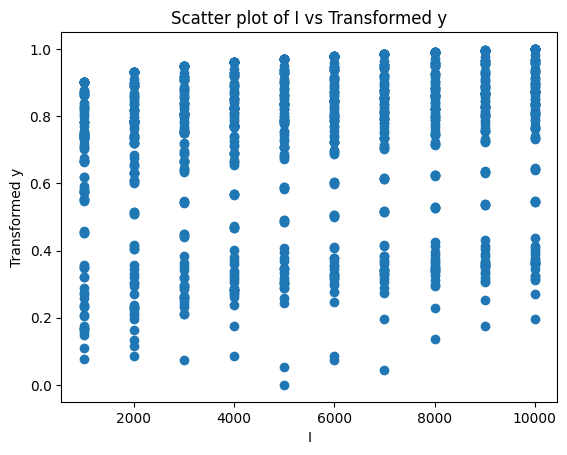

In [197]:
plt.scatter(sampled_err_df['I'], y_transformed)
plt.xlabel('I')
plt.ylabel('Transformed y')
plt.title('Scatter plot of I vs Transformed y')
plt.show()

(array([20., 20., 20., 20., 21., 20., 19., 20., 20., 20., 20., 20., 20.,
        20., 21., 20., 19., 20., 20., 20., 20., 21., 19., 20., 20., 20.,
        20., 20., 21., 19., 20., 20., 20., 20., 19., 21., 20., 21., 20.,
        18., 21., 20., 20., 20., 20., 20., 19., 21., 20., 20.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 artists>)

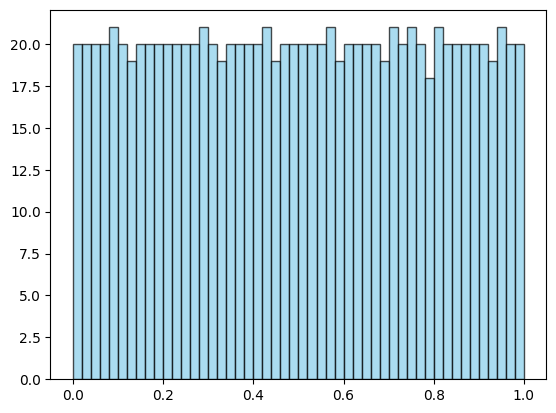

In [85]:

plt.hist(y_transformed, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
# np.log(sampled_err_df['dt']).hist(bins=50, color='skyblue', edgecolor='black', alpha=0.7)

count      1000.000000
mean      14360.699637
std       29576.764482
min           0.000007
25%           3.048499
50%        1108.113788
75%       10670.979185
max      142387.551300
Name: accumulated_error, dtype: float64


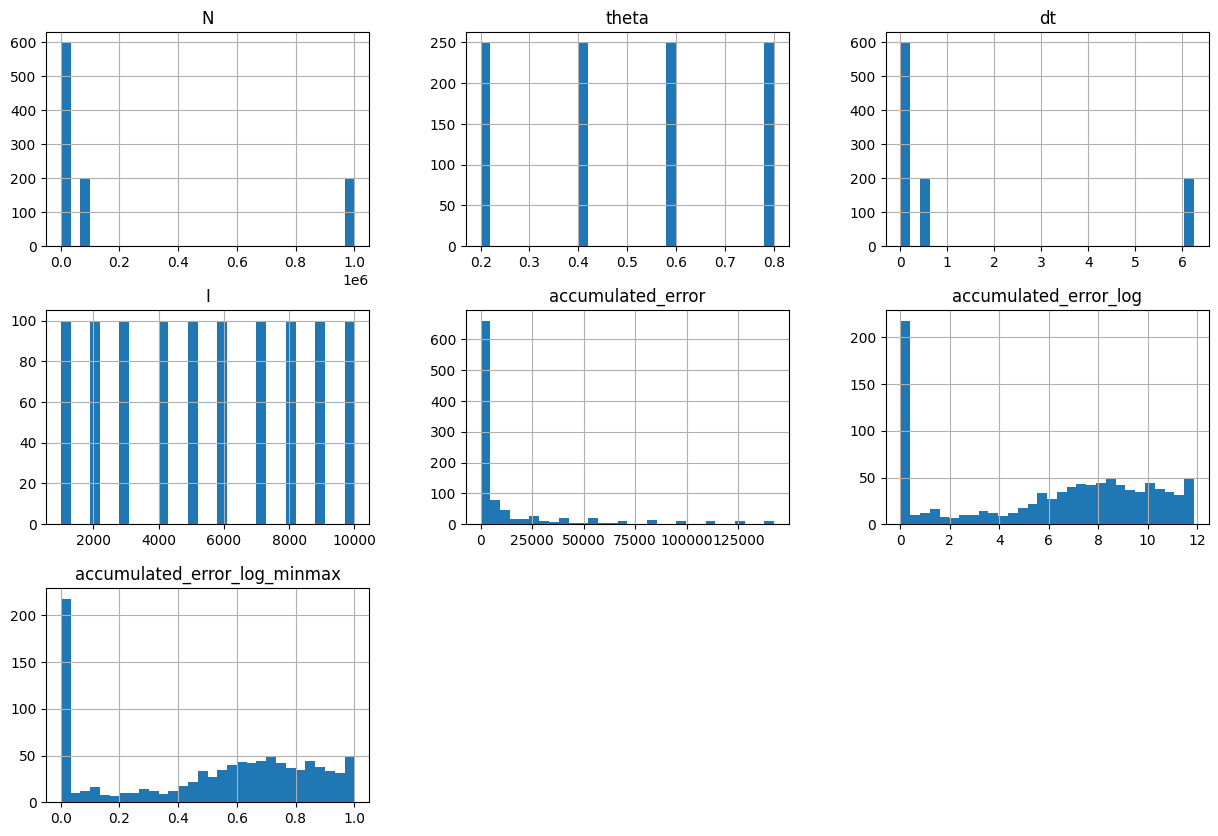

In [462]:
# np.log1p(sampled_err_df['accumulated_error'])
print(sampled_err_df['accumulated_error'].describe())

# np.power(sampled_err_df['I'], 1/10).hist()
import matplotlib.pyplot as plt
sampled_err_df.hist(bins=30, figsize=(15, 10))
plt.show()


## SVR BEST YET

In [310]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, FunctionTransformer
from sklearn.svm import SVR
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures

# Define dataset and parameters
input_features = ['N', 'theta', 'dt', 'I']
target_feature = 'accumulated_error'

# Define named functions for the transformations
def log10_transform(x):
    return np.log10(x)

def inverse_log10_transform(x):
    return np.power(10, x)


# Define the sequential transformer 
log10_scale_transformer = Pipeline(steps=[
    ('log10', FunctionTransformer(func=log10_transform, inverse_func=inverse_log10_transform)),  # Apply log10
    ('scaler', StandardScaler()),  # Apply MinMaxScaler
])

# Define the sequential transformer 
log_scale_transformer = Pipeline(steps=[
    ('log', FunctionTransformer(func=np.log, inverse_func=np.exp)),  # Apply log10
    ('scaler', StandardScaler()),  # Apply MinMaxScaler
])

# Define the transformer for N and theta columns
transformer = ColumnTransformer(
    transformers=[
        # ('quantile', StandardScaler(), []),
        # ('quantile', FunctionTransformer(func=np.log, inverse_func=np.exp), ['dt']),
        # ('quantile', QuantileTransformer(n_quantiles=10),[]), # WORKS BETTER 
        ('I', StandardScaler(), ['theta']),
        # ('powe2r', StandardScaler(), ['I','theta']), #,
        ('log', FunctionTransformer(func=log10_transform, inverse_func=inverse_log10_transform),['I']),  # Apply log10
        ('power', FunctionTransformer(func=np.log, inverse_func=np.exp), ['dt']),
        ('l10mmx', log10_scale_transformer, ['N'])
    ],
    remainder='passthrough'  # Pass through the remaining columns as they are
)

# Define the model pipeline
pipeline = Pipeline(steps=[

    # ('normalize', QuantileTransformer(n_quantiles=3)), # WORKS BETTER 
    # ('normalize2', QuantileTransformer(n_quantiles=500)), # WORKS BETTER 
    ('normalize', transformer), # WORKS BETTER 
    # ('stdscale', StandardScaler()), # WORKS BETTER 
    # ('normalize2', QuantileTransformer(n_quantiles=500)), # WORKS BETTER 
    # ('poly', PolynomialFeatures()),   # PolynomialFeatures step
    # ('model', Ridge())
    ('model', SVR()) ## SECOND BEST AND NICE GENERALIZING!!!! C=100,epsilon=0.0001
    # ('model', AdaBoostRegressor(estimator=SVR(),loss="exponential")) 
    # ('model', XGBRegressor()) 
    # ('model', DecisionTreeRegressor(random_state=42))

    # ('model', GradientBoostingRegressor(random_state=42)) ## BEST YET n_estimators=500, learning_rate=0.1, max_depth=6, 


])

# Wrap with TransformedTargetRegressor
model_poly = TransformedTargetRegressor(
    regressor=pipeline, 
    # transformer=QuantileTransformer(n_quantiles=5) #QuantileTransformer(n_quantiles=500)
    # transformer=PowerTransformer(method='box-cox') #QuantileTransformer(n_quantiles=500)
    # func=np.log1p, inverse_func=np.expm1
    transformer=log_scale_transformer
    # transformer = FunctionTransformer(func=log10_transform, inverse_func=inverse_log10_transform)
)

# Define hyperparameter grid
# model_params_poly = {
#     'regressor__poly__degree': [2, 3, 4, 5], 
#     'regressor__model__alpha': [0.0001, 0.001, 0.01,0.1,1],
# }

# Define hyperparameter grid
model_params_poly = {
    # 'regressor__model__C': [0.0001,0.001, 0.01, 0.1, 1, 10, 50,100,500,1000,2000],
    'regressor__model__C': [1000],
    # 'regressor__model__epsilon': [0.00001,0.0001, 0.001, 0.01, 0.1, 0.5, 1], 
    'regressor__model__epsilon': [0.00001,0.0001, 0.001,], 
    'regressor__model__kernel': ['rbf']
}

# adaboost
# model_params_poly = {
#     'regressor__model__n_estimators': [50],  # Boosting rounds
#     'regressor__model__learning_rate': [0.01, 0.1, 0.5],  # Learning rate
#     'regressor__model__estimator__C': [100],  # SVR C values
#     'regressor__model__estimator__epsilon': [0.0001],  # SVR epsilon
# }

# model_params_poly = {
#     'regressor__model__n_estimators': [100, 500, 1000],   # Number of boosting rounds
#     'regressor__model__learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage
#     'regressor__model__max_depth': [3, 6, 10],            # Maximum depth of trees
#     'regressor__model__min_child_weight': [1, 5, 10],     # Minimum sum of weights of all child nodes
#     'regressor__model__subsample': [0.6, 0.8, 1.0],       # Fraction of samples used for training each tree
#     'regressor__model__colsample_bytree': [0.6, 0.8, 1.0],# Fraction of features used for training each tree
#     'regressor__model__reg_alpha': [0, 0.1, 1],           # L1 regularization term
#     'regressor__model__reg_lambda': [1, 10, 50],          # L2 regularization term
# }

# Define hyperparameter grid
# model_params_poly = {
#     'regressor__model__max_depth': [2,5,10, 20, None],
#     'regressor__model__min_samples_split': [2, 5, 10],
#     'regressor__model__min_samples_leaf': [1, 2, 4],
#     'regressor__model__max_features': [0.2, 0.4, 0.6, 0.8, 1.0]
# }


# Run feature subset evaluation using Random CV
best_result_poly_test, res_poly_test = run_feature_subset_cv(
    f_full=sampled_err_df,
    input_features=input_features,
    target_feature=target_feature,
    model=model_poly,
    model_params=model_params_poly,
    output_folder="CV_results/",
    use_feature_subsets=False,
    refit_error='MAE',
    use_gpu_cv=False  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_poly_test['features'])
print("Best parameters:", best_result_poly_test['best_params'])
print("Best MAE:", best_result_poly_test['best_mae'])
print("Best MAPE:", best_result_poly_test['best_mape'])

Testing 1 feature subset(s)...


Progress:   0%|          | 0/1 [00:00<?, ?subset/s]

Custom Text:   0%|          | 0/1 [00:00<?, ?update/s]

Results saved to CV_results/SVR_Random_CV_results_193.json
Best feature subset: ['N', 'theta', 'dt', 'I']
Best parameters: {'regressor__model__C': 1000, 'regressor__model__epsilon': 1e-05, 'regressor__model__kernel': 'rbf'}
Best MAE: 71.69287420471248
Best MAPE: 0.11903916605885034


In [311]:
from sklearn.model_selection import train_test_split
from sklearn.base import clone

model_poly_final = clone(model_poly)

# model_params, selected_features = load_best_params_and_features("CV_results/SVR_Random_CV_results_187.json")
model_params, selected_features = best_result_poly_test['best_params'], best_result_poly_test['features']
# model_params, selected_features = load_best_params_and_features("CV_results/Ridge_Random_CV_results_112.json")
target_feature = 'accumulated_error'

# X_train, X_test, y_train, y_test = train_test_split(sampled_err_df[selected_features], sampled_err_df[target_feature], test_size=0.2, random_state=42)
X, y = sampled_err_df[selected_features], sampled_err_df[target_feature]
model_poly_final.set_params(**model_params)

model_poly_final.fit(X, y)

display(model_poly_final)

# Export
export_model(model_poly_final, "Models/Precision/model_poly_final_test.joblib")

TransformedTargetRegressor(regressor=Pipeline(steps=[('normalize',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        transformers=[('I',
                                                                                       StandardScaler(),
                                                                                       ['theta']),
                                                                                      ('log',
                                                                                       FunctionTransformer(func=<function log10_transform at 0x795797bb6e60>,
                                                                                                           inverse_func=<function inverse_log10_transform at 0x795797bb6b90>),
                                                                                       ['I']),
                                                                                      ('power',
                                                                                       FunctionTransformer(func=<ufunc 'log'>,
                                                                                                           inv...
                                                                                       Pipeline(steps=[('log10',
                                                                                                        FunctionTransformer(func=<function log10_transform at 0x795797bb6e60>,
                                                                                                                            inverse_func=<function inverse_log10_transform at 0x795797bb6b90>)),
                                                                                                       ('scaler',
                                                                                                        StandardScaler())]),
                                                                                       ['N'])])),
                                                     ('model',
                                                      SVR(C=1000,
                                                          epsilon=1e-05))]),
                           transformer=Pipeline(steps=[('log',
                                                        FunctionTransformer(func=<ufunc 'log'>,
                                                                            inverse_func=<ufunc 'exp'>)),
                                                       ('scaler',
                                                        StandardScaler())]))

Model exported successfully to: Models/Precision/model_poly_final_test.joblib


In [340]:

# Define named functions for the transformations
def log10_transform(x):
    return np.log10(x)

def inverse_log10_transform(x):
    return np.power(10, x)

# Define the sequential transformer 
log10_scale_transformer = Pipeline(steps=[
    ('log10', FunctionTransformer(func=log10_transform, inverse_func=inverse_log10_transform)),  # Apply log10
    ('scaler', StandardScaler()),  # Apply MinMaxScaler
])

# Define the sequential transformer 
log_scale_transformer = Pipeline(steps=[
    ('log', FunctionTransformer(func=np.log, inverse_func=np.exp)),  # Apply log10
    ('scaler', StandardScaler()),  # Apply MinMaxScaler
])

# Define the transformer for N and theta columns
transformer = ColumnTransformer(
    transformers=[
        ('I', StandardScaler(), ['theta']),
        ('log', FunctionTransformer(func=log10_transform, inverse_func=inverse_log10_transform),['I']),  # Apply log10
        ('power', FunctionTransformer(func=np.log, inverse_func=np.exp), ['dt']),
        ('l10mmx', log10_scale_transformer, ['N'])
    ],
    remainder='passthrough' 
)

# Define the model pipeline
pipeline = Pipeline(steps=[
    ('normalize', transformer), # WORKS BETTER 
    ('model', SVR()) ## SECOND BEST AND NICE GENERALIZING!!!! C=100,epsilon=0.0001
])

# Wrap with TransformedTargetRegressor
model_poly_1 = TransformedTargetRegressor(
    regressor=pipeline, 
    # transformer=QuantileTransformer(n_quantiles=5) #QuantileTransformer(n_quantiles=500)
    # transformer=PowerTransformer(method='box-cox') #QuantileTransformer(n_quantiles=500)
    # func=np.log1p, inverse_func=np.expm1
    transformer=log_scale_transformer
    # transformer = FunctionTransformer(func=log10_transform, inverse_func=inverse_log10_transform)
)

# Wrap with TransformedTargetRegressor
model1 = TransformedTargetRegressor(
    regressor=pipeline, 
    # transformer=QuantileTransformer(n_quantiles=5) #QuantileTransformer(n_quantiles=500)
    # transformer=PowerTransformer(method='box-cox') #QuantileTransformer(n_quantiles=500)
    # func=np.log1p, inverse_func=np.expm1
    transformer=log_scale_transformer
    # transformer = FunctionTransformer(func=log10_transform, inverse_func=inverse_log10_transform)
)

# Wrap with TransformedTargetRegressor
model2 = TransformedTargetRegressor(
    regressor=pipeline, 
    transformer=QuantileTransformer() #QuantileTransformer(n_quantiles=500)
    # transformer=PowerTransformer(method='box-cox') #QuantileTransformer(n_quantiles=500)
    # func=np.log1p, inverse_func=np.expm1
    # transformer=log_scale_transformer
    # transformer = FunctionTransformer(func=log10_transform, inverse_func=inverse_log10_transform)
)
from sklearn.ensemble import VotingRegressor

model1.set_params(**model_params)
model2.set_params(**model_params)

# Create a stacking regressor
stacked_model = VotingRegressor(
    estimators=[
        # ('svr_small', model1), 
        ('svr_large', model2)
    ],
    n_jobs=-1
    # final_estimator=DecisionTreeRegressor()  # Meta-model can be any regressor
)

X, y = sampled_err_df[selected_features], sampled_err_df[target_feature]

# Train the stacked model
stacked_model.fit(X, y)

export_model(stacked_model, "Models/Precision/model_stack_test.joblib")


Error exporting model: Can't pickle <function log10_transform at 0x7957951fe680>: it's not the same object as __main__.log10_transform


## Final models train and export

### Best parameter loader function

In [347]:
import json

def load_best_params_and_features(json_filename):
    try:
        # Load the JSON file
        with open(json_filename, 'r') as file:
            data = json.load(file)

        # Extract the best parameters
        best_params = data.get("best_result", {}).get("best_params", {})
        if not best_params:
            raise ValueError("No 'best_params' found in the JSON file.")

        # Extract the selected features
        selected_features = data.get("best_result", {}).get("features", [])
        if not selected_features:
            raise ValueError("No 'features' found in the JSON file.")

        # Simplify parameters to only values (not lists)
        simplified_params = {key: value[0] if isinstance(value, list) else value for key, value in best_params.items()}

        print("Loaded best parameters and selected features:")
        print("Best Parameters:", simplified_params)
        print("Selected Features:", selected_features)
        return simplified_params, selected_features

    except FileNotFoundError:
        print(f"Error: File not found - {json_filename}")
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON file - {json_filename}")
    except ValueError as ve:
        print(f"Error: {ve}")


### Export model to file

In [348]:
import joblib

def export_model(model, filename):
    try:
        # Save the model to the specified file
        joblib.dump(model, filename)
        print(f"Model exported successfully to: {filename}")
    except Exception as e:
        print(f"Error exporting model: {e}")


### Huber export

In [453]:
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn import set_config

model_huber_final = clone(model_huber)

model_params, selected_features = load_best_params_and_features("CV_results/error/HuberRegressor_Random_CV_results_69.json")
target_feature = 'accumulated_error'

# X_train, X_test, y_train, y_test = train_test_split(sampled_err_df[selected_features], sampled_err_df[target_feature], test_size=0.2, random_state=42)
X, y = sampled_err_df[selected_features], sampled_err_df[target_feature]
model_huber_final.set_params(**model_params)

model_huber_final.fit(X, y)

display(model_huber_final)

print(model_huber_final.feature_names_in_)
# # Predict and inverse transform the predictions
# y_pred = model_huber_final.predict(X_test)

# # Evaluate
# mae = mean_absolute_percentage_error(y_test, y_pred)
# print(f"Mean Absolute Error: {mae:.6f}")

# Export
export_model(model_huber_final, "Models/Precision/model_huber_final.joblib")

Loaded best parameters and selected features:
Best Parameters: {'regressor__model__alpha': 1e-05, 'regressor__model__epsilon': 2}
Selected Features: ['N', 'theta', 'dt', 'I']


TransformedTargetRegressor(regressor=Pipeline(steps=[('normalize',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        transformers=[('I',
                                                                                       StandardScaler(),
                                                                                       ['theta']),
                                                                                      ('log',
                                                                                       FunctionTransformer(func=<function log10_transform at 0x7957951fcdc0>,
                                                                                                           inverse_func=<function inverse_log10_transform at 0x7957a84684c0>),
                                                                                       ['I']),
                                                                                      ('power',
                                                                                       FunctionTransformer(func=<ufunc 'log'>,
                                                                                                           inv...
                                                                                                        FunctionTransformer(func=<function log10_transform at 0x7957951fcdc0>,
                                                                                                                            inverse_func=<function inverse_log10_transform at 0x7957a84684c0>)),
                                                                                                       ('scaler',
                                                                                                        StandardScaler())]),
                                                                                       ['N'])])),
                                                     ('model',
                                                      HuberRegressor(alpha=1e-05,
                                                                     epsilon=2))]),
                           transformer=Pipeline(steps=[('log',
                                                        FunctionTransformer(func=<ufunc 'log'>,
                                                                            inverse_func=<ufunc 'exp'>)),
                                                       ('scaler',
                                                        StandardScaler())]))

['N' 'theta' 'dt' 'I']
Model exported successfully to: Models/Precision/model_huber_final.joblib


### SVR export

In [465]:
from sklearn.model_selection import train_test_split
from sklearn.base import clone

model_svr_final = clone(model_svr)

model_params, selected_features = load_best_params_and_features("CV_results/error/SVR_Random_CV_results_68.json")
target_feature = 'accumulated_error'

sampled_err_df_minitest = sampled_err_df # .query('I <= 4000') # TEST WITH HALF DATASET, MISSING PARAMS!!

# X_train, X_test, y_train, y_test = train_test_split(sampled_err_df[selected_features], sampled_err_df[target_feature], test_size=0.2, random_state=42)
X, y = sampled_err_df_minitest[selected_features], sampled_err_df_minitest[target_feature]
model_svr_final.set_params(**model_params)

model_svr_final.fit(X, y)

display(model_svr_final)

# # Predict and inverse transform the predictions
# y_pred = model_svr_final.predict(X_test)

# # Evaluate
# mae = mean_absolute_percentage_error(y_test, y_pred)
# print(f"Mean Absolute Error: {mae:.6f}")

# Export
export_model(model_svr_final, "Models/Precision/model_svr_final.joblib")

Loaded best parameters and selected features:
Best Parameters: {'regressor__model__C': 2000, 'regressor__model__epsilon': 1e-05, 'regressor__model__kernel': 'rbf'}
Selected Features: ['N', 'theta', 'dt', 'I']


TransformedTargetRegressor(regressor=Pipeline(steps=[('normalize',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        transformers=[('scale',
                                                                                       StandardScaler(),
                                                                                       ['theta']),
                                                                                      ('log10',
                                                                                       FunctionTransformer(func=<function log10_transform at 0x7957951fcdc0>,
                                                                                                           inverse_func=<function inverse_log10_transform at 0x7957a84684c0>),
                                                                                       ['I']),
                                                                                      ('log',
                                                                                       FunctionTransformer(func=<ufunc 'log'>...
                                                                                       Pipeline(steps=[('log10',
                                                                                                        FunctionTransformer(func=<function log10_transform at 0x7957951fcdc0>,
                                                                                                                            inverse_func=<function inverse_log10_transform at 0x7957a84684c0>)),
                                                                                                       ('scaler',
                                                                                                        StandardScaler())]),
                                                                                       ['N'])])),
                                                     ('model',
                                                      SVR(C=2000,
                                                          epsilon=1e-05))]),
                           transformer=Pipeline(steps=[('log',
                                                        FunctionTransformer(func=<ufunc 'log'>,
                                                                            inverse_func=<ufunc 'exp'>)),
                                                       ('scaler',
                                                        StandardScaler())]))

Model exported successfully to: Models/Precision/model_svr_final.joblib


### DT export

In [385]:
from sklearn.model_selection import train_test_split
from sklearn.base import clone

model_dt_final = clone(model_dt)

model_params, selected_features = load_best_params_and_features("CV_results/error/DecisionTreeRegressor_Random_CV_results_16.json")
target_feature = 'accumulated_error'

# X_train, X_test, y_train, y_test = train_test_split(sampled_err_df[selected_features], sampled_err_df[target_feature], test_size=0.2, random_state=42)
X, y = sampled_err_df[selected_features], sampled_err_df[target_feature]
model_dt_final.set_params(**model_params)

model_dt_final.fit(X, y)

display(model_dt_final)

# # Predict and inverse transform the predictions
# y_pred = model_dt_final.predict(X_test)

# # Evaluate
# mae = mean_absolute_percentage_error(y_test, y_pred)
# print(f"Mean Absolute Error: {mae:.6f}")

# Export
export_model(model_dt_final, "Models/Precision/model_dt_final.joblib")

Loaded best parameters and selected features:
Best Parameters: {'regressor__model__max_depth': 20, 'regressor__model__max_features': 1.0, 'regressor__model__min_samples_leaf': 1, 'regressor__model__min_samples_split': 5}
Selected Features: ['N', 'theta', 'dt', 'I']


TransformedTargetRegressor(regressor=Pipeline(steps=[('normalize',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        transformers=[('I',
                                                                                       StandardScaler(),
                                                                                       ['theta']),
                                                                                      ('log',
                                                                                       FunctionTransformer(func=<function log10_transform at 0x7957951fcca0>,
                                                                                                           inverse_func=<function inverse_log10_transform at 0x7957951fcc10>),
                                                                                       ['I']),
                                                                                      ('power',
                                                                                       FunctionTransformer(func=<ufunc 'log'>,
                                                                                                           inv...
                                                                                                        FunctionTransformer(func=<function log10_transform at 0x7957951fcca0>,
                                                                                                                            inverse_func=<function inverse_log10_transform at 0x7957951fcc10>)),
                                                                                                       ('scaler',
                                                                                                        StandardScaler())]),
                                                                                       ['N'])])),
                                                     ('model',
                                                      DecisionTreeRegressor(max_depth=20,
                                                                            max_features=1.0,
                                                                            min_samples_split=5,
                                                                            random_state=42))]),
                           transformer=Pipeline(steps=[('log',
                                                        FunctionTransformer(func=<ufunc 'log'>,
                                                                            inverse_func=<ufunc 'exp'>)),
                                                       ('scaler',
                                                        StandardScaler())]))

Model exported successfully to: Models/Precision/model_dt_final.joblib


### GB export

In [390]:
from sklearn.model_selection import train_test_split
from sklearn.base import clone

model_gb_final = clone(model_gb)

model_params, selected_features = load_best_params_and_features("CV_results/error/GradientBoostingRegressor_Random_CV_results_20.json")
target_feature = 'accumulated_error'

# X_train, X_test, y_train, y_test = train_test_split(sampled_err_df[selected_features], sampled_err_df[target_feature], test_size=0.2, random_state=42)
X, y = sampled_err_df[selected_features], sampled_err_df[target_feature]
model_gb_final.set_params(**model_params)

model_gb_final.fit(X, y)

display(model_gb_final)

# # Predict and inverse transform the predictions
# y_pred = model_gb_final.predict(X_test)

# # Evaluate
# mae = mean_absolute_percentage_error(y_test, y_pred)
# print(f"Mean Absolute Error: {mae:.6f}")

# Export
export_model(model_gb_final, "Models/Precision/model_gb_final.joblib")

Loaded best parameters and selected features:
Best Parameters: {'regressor__model__learning_rate': 0.1, 'regressor__model__max_depth': 10, 'regressor__model__max_features': 1.0, 'regressor__model__min_samples_leaf': 2, 'regressor__model__min_samples_split': 2, 'regressor__model__n_estimators': 200, 'regressor__model__subsample': 0.8}
Selected Features: ['N', 'theta', 'dt', 'I']


TransformedTargetRegressor(regressor=Pipeline(steps=[('normalize',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        transformers=[('I',
                                                                                       StandardScaler(),
                                                                                       ['theta']),
                                                                                      ('log',
                                                                                       FunctionTransformer(func=<function log10_transform at 0x795797a8b250>,
                                                                                                           inverse_func=<function inverse_log10_transform at 0x795797a8b400>),
                                                                                       ['I']),
                                                                                      ('power',
                                                                                       FunctionTransformer(func=<ufunc 'log'>,
                                                                                                           inv...
                                                                                                                            inverse_func=<function inverse_log10_transform at 0x795797a8b400>)),
                                                                                                       ('scaler',
                                                                                                        StandardScaler())]),
                                                                                       ['N'])])),
                                                     ('model',
                                                      GradientBoostingRegressor(max_depth=10,
                                                                                max_features=1.0,
                                                                                min_samples_leaf=2,
                                                                                n_estimators=200,
                                                                                random_state=42,
                                                                                subsample=0.8))]),
                           transformer=Pipeline(steps=[('log',
                                                        FunctionTransformer(func=<ufunc 'log'>,
                                                                            inverse_func=<ufunc 'exp'>)),
                                                       ('scaler',
                                                        StandardScaler())]))

Model exported successfully to: Models/Precision/model_gb_final.joblib


### ERT export

In [411]:
from sklearn.model_selection import train_test_split
from sklearn.base import clone

model_ert_final = clone(model_ert)

model_params, selected_features = load_best_params_and_features("CV_results/error/ExtraTreesRegressor_Random_CV_results_9.json")
target_feature = 'accumulated_error'

# X_train, X_test, y_train, y_test = train_test_split(sampled_err_df[selected_features], sampled_err_df[target_feature], test_size=0.2, random_state=42)
X, y = sampled_err_df[selected_features], sampled_err_df[target_feature]
model_ert_final.set_params(**model_params)

model_ert_final.fit(X, y)

display(model_ert_final)

# # Predict and inverse transform the predictions
# y_pred = model_ert_final.predict(X_test)

# # Evaluate
# mae = mean_absolute_percentage_error(y_test, y_pred)
# print(f"Mean Absolute Error: {mae:.6f}")

# Export
export_model(model_ert_final, "Models/Precision/model_ert_final.joblib")

Loaded best parameters and selected features:
Best Parameters: {'regressor__model__max_depth': 20, 'regressor__model__max_features': 1.0, 'regressor__model__min_samples_leaf': 1, 'regressor__model__min_samples_split': 2, 'regressor__model__n_estimators': 100}
Selected Features: ['N', 'theta', 'dt', 'I']


TransformedTargetRegressor(regressor=Pipeline(steps=[('normalize',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        transformers=[('I',
                                                                                       StandardScaler(),
                                                                                       ['theta']),
                                                                                      ('log',
                                                                                       FunctionTransformer(func=<function log10_transform at 0x7957a90efd00>,
                                                                                                           inverse_func=<function inverse_log10_transform at 0x7957a90eef80>),
                                                                                       ['I']),
                                                                                      ('power',
                                                                                       FunctionTransformer(func=<ufunc 'log'>,
                                                                                                           inv...
                                                                                                        FunctionTransformer(func=<function log10_transform at 0x7957a90efd00>,
                                                                                                                            inverse_func=<function inverse_log10_transform at 0x7957a90eef80>)),
                                                                                                       ('scaler',
                                                                                                        StandardScaler())]),
                                                                                       ['N'])])),
                                                     ('model',
                                                      ExtraTreesRegressor(max_depth=20,
                                                                          random_state=42))]),
                           transformer=Pipeline(steps=[('log',
                                                        FunctionTransformer(func=<ufunc 'log'>,
                                                                            inverse_func=<ufunc 'exp'>)),
                                                       ('scaler',
                                                        StandardScaler())]))

Model exported successfully to: Models/Precision/model_ert_final.joblib


### Poly ridge export

In [421]:
from sklearn.model_selection import train_test_split
from sklearn.base import clone

model_poly_final = clone(model_poly)

model_params, selected_features = load_best_params_and_features("CV_results/error/Ridge_Random_CV_results_8.json")
target_feature = 'accumulated_error'

# X_train, X_test, y_train, y_test = train_test_split(sampled_err_df[selected_features], sampled_err_df[target_feature], test_size=0.2, random_state=42)
X, y = sampled_err_df[selected_features], sampled_err_df[target_feature]
model_poly_final.set_params(**model_params)

model_poly_final.fit(X, y)

display(model_poly_final)

# # Predict and inverse transform the predictions
# y_pred = model_poly_final.predict(X_test)

# # Evaluate
# mae = mean_absolute_percentage_error(y_test, y_pred)
# print(f"Mean Absolute Error: {mae:.6f}")

# Export
export_model(model_poly_final, "Models/Precision/model_poly_final.joblib")

Loaded best parameters and selected features:
Best Parameters: {'regressor__model__alpha': 1, 'regressor__poly__degree': 6}
Selected Features: ['N', 'theta', 'dt', 'I']


TransformedTargetRegressor(regressor=Pipeline(steps=[('normalize',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        transformers=[('I',
                                                                                       StandardScaler(),
                                                                                       ['theta']),
                                                                                      ('log',
                                                                                       FunctionTransformer(func=<function log10_transform at 0x7957a8468790>,
                                                                                                           inverse_func=<function inverse_log10_transform at 0x7957a8468670>),
                                                                                       ['I']),
                                                                                      ('power',
                                                                                       FunctionTransformer(func=<ufunc 'log'>,
                                                                                                           inv...
                                                                                                        FunctionTransformer(func=<function log10_transform at 0x7957a8468790>,
                                                                                                                            inverse_func=<function inverse_log10_transform at 0x7957a8468670>)),
                                                                                                       ('scaler',
                                                                                                        StandardScaler())]),
                                                                                       ['N'])])),
                                                     ('poly',
                                                      PolynomialFeatures(degree=6)),
                                                     ('model',
                                                      Ridge(alpha=1))]),
                           transformer=Pipeline(steps=[('log',
                                                        FunctionTransformer(func=<ufunc 'log'>,
                                                                            inverse_func=<ufunc 'exp'>)),
                                                       ('scaler',
                                                        StandardScaler())]))

Model exported successfully to: Models/Precision/model_poly_final.joblib


## Tests

### direct test

In [26]:
model_gb_final.predict([[100000,0.2,0.0625, 10000]])

NameError: name 'model_gb_final' is not defined

### compare against model

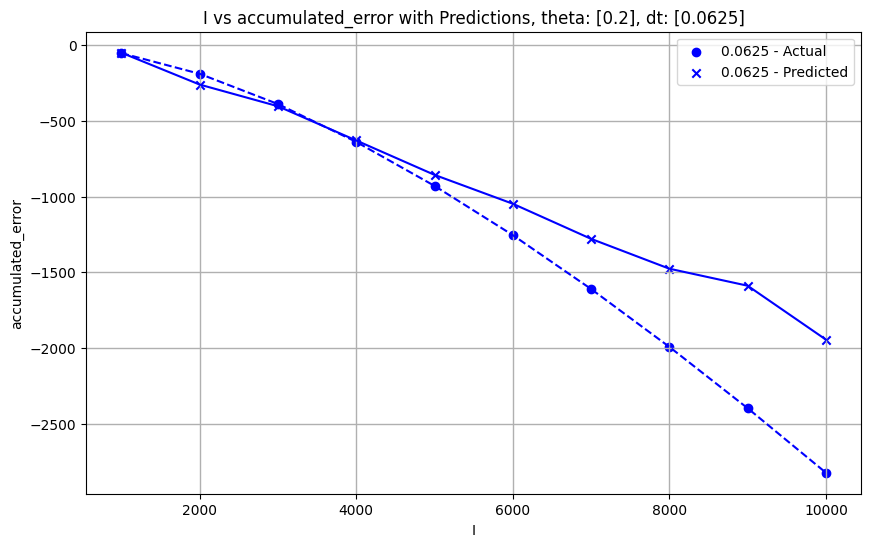

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

df = sampled_err_df.copy()
model = model_poly_final

# Define the filter criteria
filter_criteria = {
    'theta': [0.2],
    'N': [100000],
    # 'I': [10000],
    'dt': [0.0625]
}

# Apply filtering based on the filter criteria
for feature, values in filter_criteria.items():
    df = df[df[feature].isin(values)]

# Add predictions to the filtered dataset
df['predicted_accumulated_error'] = model.predict(df[['N', 'theta', 'dt', 'I']])

# Group by a specific feature
grouped = df.groupby('dt')

# Plot X vs y for each group
colors = ['blue', 'green', 'red', 'purple', 'yellow']  # Specify colors for each group if known

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot X vs y with scatter points and connect them with dashed lines for each group
for (group_name, group_data), color in zip(grouped, colors):
    # Plot actual values
    ax.scatter(group_data['I'], group_data['accumulated_error'], color=color, label=f'{group_name} - Actual')
    ax.plot(group_data['I'], group_data['accumulated_error'], linestyle='--', color=color)  # Dashed line for actual
    
    # Plot predicted values
    ax.scatter(group_data['I'], group_data['predicted_accumulated_error'], color=color, marker='x', label=f'{group_name} - Predicted')
    ax.plot(group_data['I'], group_data['predicted_accumulated_error'], linestyle='-', color=color)  # Solid line for predicted

# Add grid and logarithmic scales
ax.grid(linestyle='-', linewidth=1)
# ax.set_yscale("asinh")         # Logarithmic scale for y-axis

# Add labels, title, and legend
ax.set_xlabel('I')
ax.set_ylabel('accumulated_error')
ax.set_title('I vs accumulated_error with Predictions, theta: [0.2], dt: [0.0625]')
ax.legend()

# Set x and y limits to cover the range of points
# ax.set_xlim(df['I'].min() - 1, df['I'].max() + 1)
# ax.set_ylim(df['accumulated_error'].min() * 0.8, df['accumulated_error'].max() * 1.2)

plt.show()

# COMPARAR CON: https://top500.org/system/179842/


EXPORT LIMITED: .query('I <= 4000') 

count    1.100000e+03
mean     1.305538e+04
std      2.849984e+04
min      4.488800e-10
25%      1.138416e-01
50%      6.329041e+02
75%      7.855092e+03
max      1.423876e+05
Name: accumulated_error, dtype: float64


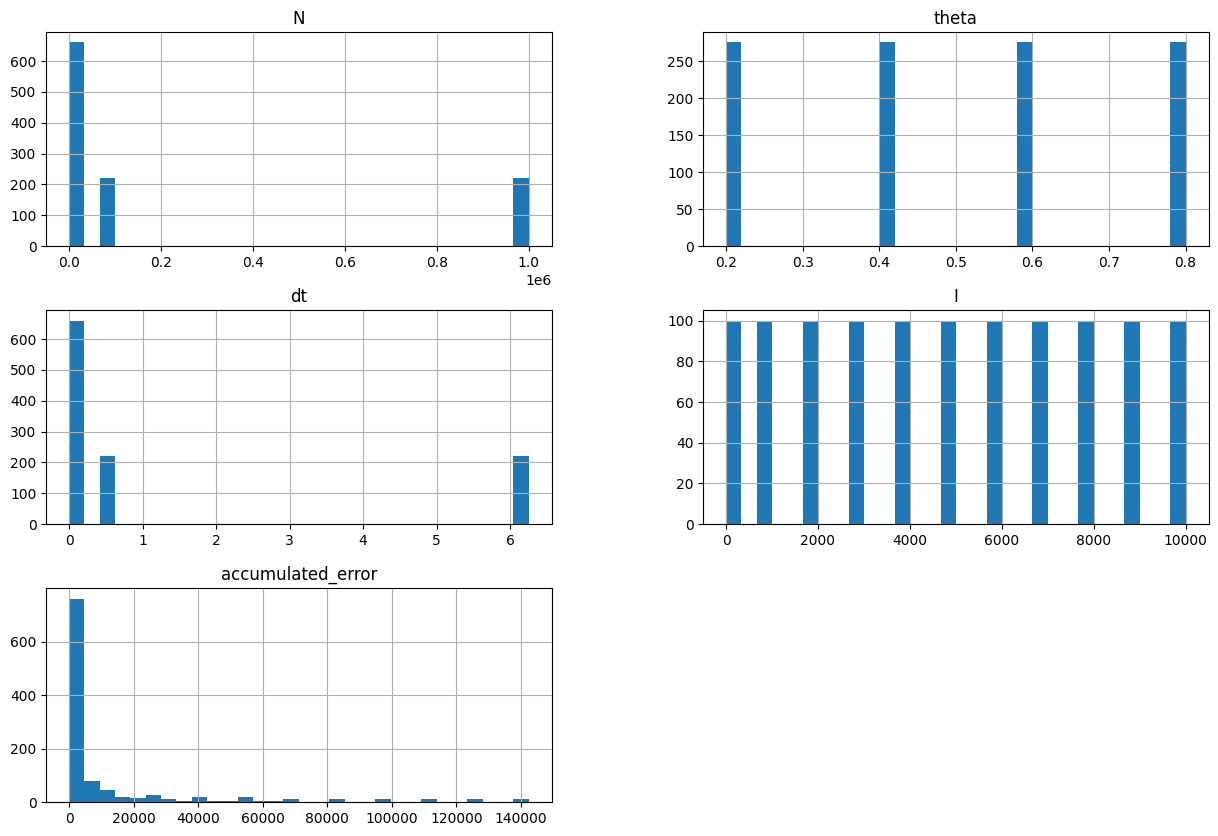

In [395]:
# np.log1p(sampled_err_df['accumulated_error'])
print(sampled_err_df['accumulated_error'].describe())

# np.power(sampled_err_df['I'], 1/10).hist()
import matplotlib.pyplot as plt
sampled_err_df.hist(bins=30, figsize=(15, 10))
plt.show()
